<a href="https://colab.research.google.com/github/rkaclfdl123/TIL/blob/master/%EB%B2%84%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 버스 운행시간 데이터를 활용한 데이터 분석
- 버스가 다음 정류장에 도착하기 위해서 걸릴 시간을 예측

## 1. 라이브러리 및 데이터
## Library & Data

In [241]:
## matplotlib 사용시 한국어 나오게 하는 코드

!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# 그래프에 retina display 적용

%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정

plt.rc('font', family='NanumBarunGothic') 



In [242]:
import pandas as pd #판다스 패키지 불러오기
import lightgbm as lgb
import folium #지리정보시각화패키지

In [243]:
# 데이터 불러오기
train = pd.read_csv('/train.csv')
test = pd.read_csv('/test.csv')
submission = pd.read_csv('/submission_제출양식.csv')

In [244]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 탐색적 자료분석
## Exploratory Data Analysis (EDA)


### pd.DataFrame.head()
 - 데이터 프레임의 위에서 부터 n개 행을 보여주는 함수
 - n의 기본 값(default 값)은 5

In [245]:
train['distance']

0         266.0
1         333.0
2         415.0
3         578.0
4         374.0
          ...  
210452    528.0
210453    280.0
210454    114.0
210455    223.0
210456    189.0
Name: distance, Length: 210457, dtype: float64

+ id : 고유 id
+ date : 버스 운행 날짜
+ route_id : 버스 노선 ID
+ vh_id : 버스 id
+ route_nm : 버스 노선 실제 번호
+ now_latitude : 현재 정류소의 위도
+ now_longitude : 현재 정류소의 경도
+ now_station : 현재 정류소 이름
+ now_arrive_time : 현재 정류장에 도착한 시간
+ distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
+ next_station : 다음 정류소 이름
+ next_latitude : 다음 정류소의 위도
+ next_longitude : 다음 정류소의 경도
+ next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값



In [246]:
train[['route_id','vh_id']].drop_duplicates()

,route_id,vh_id
0,405136001,7997025
181,405136001,7997034
381,405136001,7997035
539,405136001,7997040
717,405136001,7997044
...,...,...
20226,405136522,7997004
26037,405320116,7983225
27098,405320122,7983067
45506,405328102,7983401


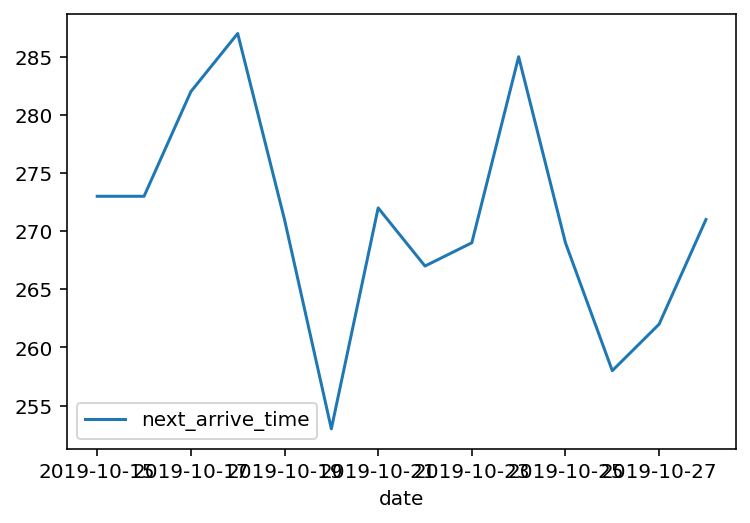

In [247]:
train[['date','next_arrive_time']].drop_duplicates().groupby('date').count().plot()

In [248]:
train[['route_id','vh_id']].drop_duplicates().groupby('route_id').count()

,vh_id
route_id,
405136001,10
405136002,5
405136007,1
405136012,3
405136521,6
405136522,15
405320111,3
405320112,5
405320113,1


In [249]:
train['date']=(train['date'].str.rpartition(sep='-')[2].astype('int'))%7


In [250]:
test['date']=(test['date'].str.rpartition(sep='-')[2].astype('int'))%7

### pd.DataFrame.tail()
 - 데이터 프레임의 아래에서 부터 n개 행을 보여주는 함수
 - n의 기본 값(default 값)은 5

In [251]:
train.tail()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
210452,210452,0,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96
210453,210453,0,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50
210454,210454,0,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16
210455,210455,0,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38
210456,210456,0,405328102,7983486,281-2,33.248487,126.511195,대륜동주민센터,21시,189.0,서귀포버스터미널(가상정류소),33.249091,126.509224,24


### pd.DataFrame.shape
 - 데이터 프레임의 행의 개수와 열의 개수가 저장되어 있는 속성(attribute)

In [252]:
train.shape

(210457, 14)

### pd.DataFrame.info()
- 데이터셋의 column별 정보를 알려주는 함수
- 비어 있지 않은 값은 (non-null)은 몇개인지?
- column의 type은 무엇인지?
 - type의 종류 : int(정수), float(실수), object(문자열), 등등 (date, ...)

In [253]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  int64  
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 22.5+ MB


### pd.DataFrame.describe()
- 숫자형 (int, float) column들의 기술 통계량을 보여주는 함수

- 기술통계량이란?
 - 해당 column을 대표할 수 있는 통계값들을 의미
 
 
- 기술통계량 종류
 - count: 해당 column에서 비어 있지 않은 값의 개수
 - mean: 평균
 - std: 표준편차
 - min: 최솟값 (이상치 포함)
 - 25% (Q1): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 1/4번째 지점에 있는 값
 - 50% (Q2): 중앙값 (전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 2/4번째 지점에 있는 값)
 - 75% (Q3): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 3/4번째 지점에 있는 값
 - max: 최댓값 (이상치 포함) 
 
 
 
- 이상치: 울타리 밖에 있는 부분을 이상치라고 정의함
   - 아래쪽 울타리: $Q_1$ - $1.5 * IQR$
   - 위쪽 울타리: $Q_3$ + $1.5 * IQR$
   - $IQR$ = $Q_3 - Q_1$
 
 
<img src="https://miro.medium.com/max/10125/1*NRlqiZGQdsIyAu0KzP7LaQ.png" width="700" height="500">

### pd.DataFrame.groupby()
 - 집단에 대한 통계량 확인 
 
<img src="https://s3.amazonaws.com/files.dezyre.com/images/Tutorials/Split+Apply+Combine+Strategy.png" width="700" height="500">

### folium.Map()
 - location 옵션에 있는 좌표를 중심으로 지도 시각화

In [254]:
coord = [35.1559361, 129.1384361] #부산시의 좌표 coord에 저장함
map_osm = folium.Map(location = coord) 
map_osm

In [255]:
map_osm = folium.Map(location=coord, zoom_start=12)
map_osm

In [256]:
map_osm = folium.Map(location = coord, tiles = 'Stamen Terrain')
map_osm

In [257]:
map_osm = folium.Map(location = coord, tiles = 'Stamen Toner')
map_osm

In [258]:
coord = [35.2335123, 129.0810047]

map_osm = folium.Map(location=coord, zoom_start=12)

folium.Marker(coord, popup='부산대학교', tooltip = '부산대학교 tooltip').add_to(map_osm) # 마커 생성 뒤 지도에 추가해주는 기능

map_osm.save('index.html')

map_osm

default images: https://getbootstrap.com/docs/3.3/components/

- 검색 기능이 없다

fontawesome:https://fontawesome.com/icons?d=gallery

- 해당링크의 무료인것만 쓸 수 있음

In [259]:
map_osm = folium.Map(location=coord, zoom_start=12)
folium.Marker(coord, popup='부산대학교', icon=folium.Icon(icon='star')).add_to(map_osm)
map_osm

In [260]:
map_osm = folium.Map(location=[37.541, 126.986], zoom_start=11)
folium.Marker([37.566345, 126.977893], popup='서울특별시청', icon=folium.Icon(color='red',icon='info-sign')).add_to(map_osm)
folium.Circle([37.4600, 126.9519], tooltip='서울대학교', radius=3000, color="green").add_to(map_osm)
folium.CircleMarker([37.5662, 126.9386], radius=10, popup='연세대학교',color="black", fill_color="crimson").add_to(map_osm)
map_osm

In [261]:
map_osm = folium.Map(location=[37.541, 126.986], zoom_start=11)
folium.RegularPolygonMarker([37.566345, 126.977893], popup='서울특별시청', fill_color='red',color='red', number_of_sides=3, radius=30, fill_opacity=0.2).add_to(map_osm)
folium.RegularPolygonMarker([37.4600, 126.9519], popup='서울대학교', fill_color='green',color='green', number_of_sides=4, radius=10, fill_opacity=0.2).add_to(map_osm)
folium.RegularPolygonMarker([37.5662, 126.9386], popup='연세대학교',fill_color='blue',color='blue', number_of_sides=6, radius=10).add_to(map_osm)
map_osm

In [262]:
map_data = train[['route_id','now_latitude','now_longitude','now_station']]
map_bus_route = map_data[map_data['route_id'] == 405320122].drop_duplicates("now_station")


map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)


for item in map_bus_route.index:
    lat = map_bus_route.loc[item,'now_latitude']
    long = map_bus_route.loc[item,'now_longitude']
    
    folium.Marker([lat,long], popup = map_bus_route.loc[item,'now_station'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm)

map_osm.save('index.html')

map_osm

## 3. 데이터 전처리
## Data Cleansing & Pre-Processing  

### pd.Series.str.slice()
- Series 내에 문자열을 일괄적으로 slicing (자르기)

In [263]:

test['now_arrive_time']=test['now_arrive_time'].str.slice(stop=-1).astype('int')

In [264]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91774 entries, 0 to 91773
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               91774 non-null  int64  
 1   date             91774 non-null  int64  
 2   route_id         91774 non-null  int64  
 3   vh_id            91774 non-null  int64  
 4   route_nm         91774 non-null  object 
 5   now_latitude     91774 non-null  float64
 6   now_longitude    91774 non-null  float64
 7   now_station      91774 non-null  object 
 8   now_arrive_time  91774 non-null  int64  
 9   distance         91774 non-null  float64
 10  next_station     91774 non-null  object 
 11  next_latitude    91774 non-null  float64
 12  next_longitude   91774 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 9.1+ MB


## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [265]:
X-->>MODEL-->>Y

SyntaxError: ignored

In [ ]:
features=['now_latitude','now_longitude','now_arrive_time','distance','date']
target=['next_arrive_time']

In [ ]:
X_train, X_test,Y_train=train[features],test[features],train[target]

In [ ]:
['date']

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [266]:
model_dict={
    # 'linear':LinearRegression(),
    'RF':RandomForestRegressor(random_state=0,n_jobs=-1,max_depth=10,min_samples_leaf=8,min_samples_split=8),
    # 'lgbm':lgb.LGBMRegressor(random_state=0)
}

In [ ]:
model_dict['RF']

In [267]:
model_dict['RF'].fit(X_train,Y_train)


ValueError: ignored

In [ ]:
 model_result['RF']=model_dict['RF'].predict(X_test)

In [ ]:
model_result={}
for key in model_dict.keys():
  print("#####훈련중######")
  model_dict[key].fit(X_train,Y_train)
  print("#####예측중######")
  model_result[key]=model_dict[key].predict(X_test)
  

In [ ]:
# lr_submit=submission.copy()
rf_submit=submission.copy()
# lgbm_submit=submission.copy()

In [ ]:
# lr_submit['next_arrive_time']=model_result['linear']
rf_submit['next_arrive_time']=model_result['RF']
# lgbm_submit['next_arrive_time']=model_result['lgbm']

In [ ]:
lr_submit.to_csv('linear_submit(date2).csv', index=False)
rf_submit.to_csv('RF_submit(date2).csv', index=False)
lgbm_submit.to_csv('lgbm_submit(date2).csv', index=False)

## 6. 결과 및 결언
## Conclusion & Discussion